# SLC32A1

Heterozyogous variants in SLC32A1 are associated with
two autosomal dominant conditions, [developmental and epileptic encephalopathy-114 (DEE114)](https://omim.org/entry/620774)
and [generalized epilepsy with febrile seizures plus-12 (GEFSP12)](https://omim.org/entry/620755).

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}.')
print(f"Using gpsea version {gpsea.__version__}.")

Loaded HPO v2025-01-16.
Using gpsea version 0.9.4.


### SLC32A1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SLC32A1.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'SLC32A1'
mane_tx_id = 'NM_080552.3'
mane_protein_id = 'NP_542119.1' # vesicular inhibitory amino acid transporter
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 38 phenopackets
Individuals Processed: 100%|██████████| 38/38 [00:00<00:00, 1342.05 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
23,Febrile seizure (within the age range of 3 months to 6 years)
11,Generalized-onset seizure
7,Focal-onset seizure
4,Hypotonia
4,Developmental regression
4,Motor delay
4,Delayed speech and language development
4,Intellectual disability
3,Bilateral tonic-clonic seizure with generalized onset
3,Focal impaired awareness seizure


/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_23732/4290335241.py:21: DeprecationWarning: draw_protein_diagram was deprecated and will be removed in `1.0.0`. Use `draw_protein` instead
  visualizer.draw_protein_diagram(


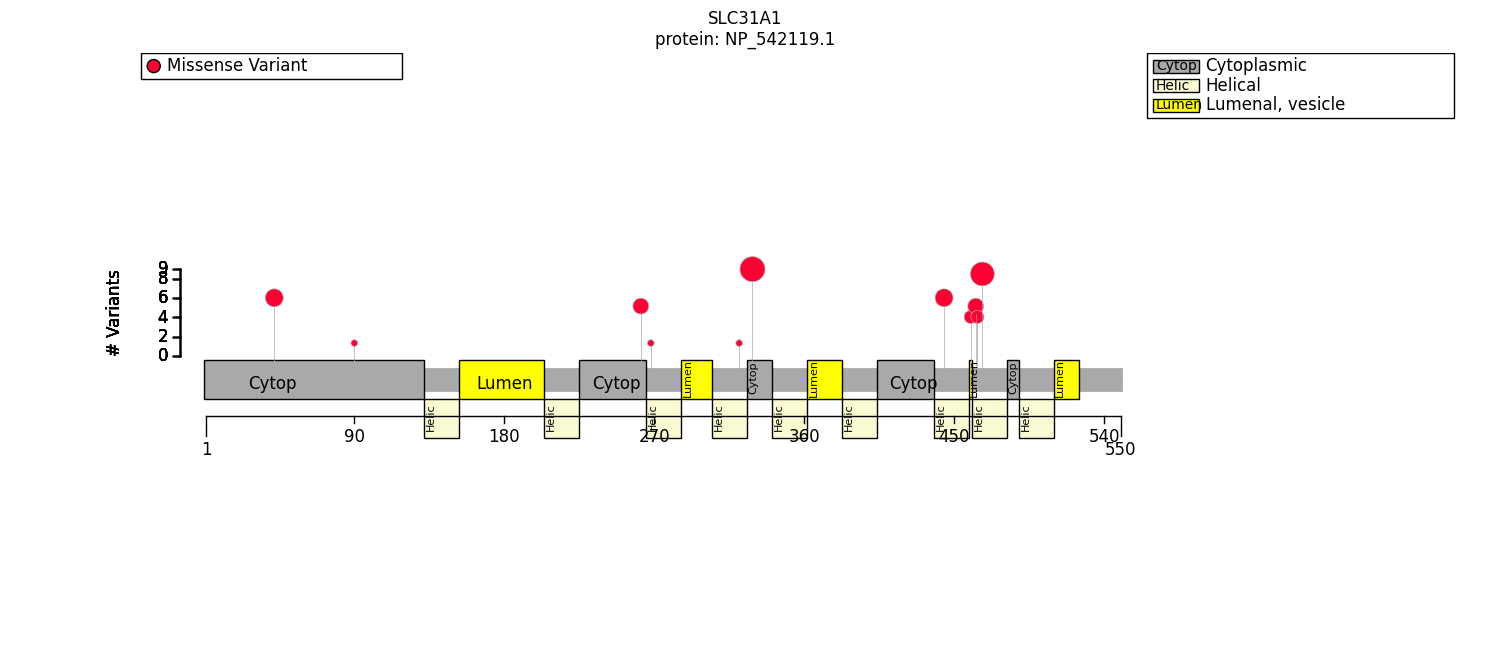

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="SLC31A1",
        uniprot_json="Q9H598.json",
        protein_length=550,
)

slc32a1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
slc32a1_fig.tight_layout()

# Genotype Phenotype Correlation (GPC) Analysis

No genotype-phenotype correlations were identified in the published literature. All pathogenic variants are missense. Therefore, we will search for the most common variant and for N-terminal vs. C-terminal.

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.model.genome import Region
from gpsea.view import MtcStatsViewer
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import protein_region

n_term = protein_region(region=Region(0, 360), tx_id=mane_tx_id)
nterm_clf = monoallelic_classifier(
    a_predicate=n_term,
    b_predicate=~n_term,
    a_label="N term",
    b_label="other"
)

nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=nterm_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(nterm_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,28
HMF03,Skipping term because of a child term with the same individual counts,1
HMF08,Skipping general term,37
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,75


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group,N term,other,Corrected p values,p values
Febrile seizure (within the age range of 3 months to 6 years) [HP:0002373],8/15 (53%),15/18 (83%),0.505451,0.126363
Seizure [HP:0001250],17/17 (100%),19/19 (100%),1.000000,1.000000
Generalized-onset seizure [HP:0002197],7/7 (100%),10/10 (100%),1.000000,1.000000
Seizure precipitated by febrile infection [HP:0032894],8/8 (100%),15/15 (100%),1.000000,1.000000


In [9]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Febrile seizure (within the age range of 3 months to 6 years) [HP:0002373],11/17 (65%),12/16 (75%),1.0,0.707985
Seizure precipitated by febrile infection [HP:0032894],11/11 (100%),12/12 (100%),1.0,1.000000
Seizure [HP:0001250],17/17 (100%),19/19 (100%),1.0,1.000000
Generalized-onset seizure [HP:0002197],9/9 (100%),8/8 (100%),1.0,1.000000


In [10]:
from gpsea.analysis.predicate import variant_key

met330thr = variant_key("20_38728050_38728050_T_C") # c.989T>C	p.Met330Thr
met330thr_clf = monoallelic_classifier(
    a_predicate=met330thr,
    b_predicate= ~met330thr,
    a_label='p.Met330Thr',
     b_label= 'Other variant'
)
met330thr_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=met330thr_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=met330thr_result)

Allele group,p.Met330Thr,Other variant,Corrected p values,p values
Generalized-onset seizure [HP:0002197],3/3 (100%),14/14 (100%),1.0,1.0
Seizure precipitated by febrile infection [HP:0032894],6/6 (100%),17/17 (100%),1.0,1.0
Febrile seizure (within the age range of 3 months to 6 years) [HP:0002373],6/9 (67%),17/24 (71%),1.0,1.0
Seizure [HP:0001250],9/9 (100%),27/27 (100%),1.0,1.0


# Summary

In [11]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=nterm_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=met330thr_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

caption = "No significant correlation identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [12]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
N term,other,4,0
Genotype (A),Genotype (B),Tests performed,Significant tests
p.Met330Thr,Other variant,4,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,4,0


In [13]:
summarizer.process_latex(report=report, protein_fig=slc32a1_fig)

Figure saved to ../../supplement/img/SLC32A1_protein_diagram-draft.pdf
Output to ../../supplement/tex/SLC32A1_summary_draft.tex
